# Scatter Plots of Heat & Salt budget for SOSE
(to check budget closes on every grid point)

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)
client = cluster.get_client()

In [16]:
client

<Client: 'tls://10.37.117.2:8786' processes=2 threads=4, memory=17.18 GB>

In [66]:
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

In [4]:
xr.set_options(display_style='text')

## HEAT Scatter Plot

In [5]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))
ds

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    surface_flux_conv_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 320, 2160, 42), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [6]:
coords = ds.coords.to_dataset().reset_coords().roll(XC=700)#, XG=700)
dsr = ds.reset_coords(drop=True).roll(XC=700)#, XG=700)

<ipython-input-6-67fe7accb339>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords = ds.coords.to_dataset().reset_coords().roll(XC=700)#, XG=700)
<ipython-input-6-67fe7accb339>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  dsr = ds.reset_coords(drop=True).roll(XC=700)#, XG=700)


In [7]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds_orig_sose = xr.open_zarr(mapping, consolidated=True)

In [8]:
coords_orig_sose = ds_orig_sose.coords.to_dataset().reset_coords().roll(XC=700)
dsr_orig_sose = ds_orig_sose.reset_coords(drop=True).roll(XC=700)

<ipython-input-8-b697d7019408>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_orig_sose = ds_orig_sose.coords.to_dataset().reset_coords().roll(XC=700)
<ipython-input-8-b697d7019408>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  dsr_orig_sose = ds_orig_sose.reset_coords(drop=True).roll(XC=700)


In [9]:
ds = dsr

In [10]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
#WG model's boundaries after .roll(XC=700) (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [11]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [12]:
ds.surface_flux_conv_TH

<xarray.DataArray 'surface_flux_conv_TH' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [13]:
rhs =  (ds.surface_flux_conv_TH
        + ds.conv_horiz_adv_flux_TH + ds.conv_vert_adv_flux_TH
        + ds.conv_horiz_diff_flux_TH + ds.conv_vert_diff_flux_TH
        + ds.sw_flux_conv_TH + ds.lin_fs_correction_TH)
lhs = ds.total_tendency_TH_truth

In [14]:
rhs

<xarray.DataArray (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<add, shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [15]:
lhs

<xarray.DataArray 'total_tendency_TH_truth' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 42, 320, 2160), dtype=float64, chunksize=(1, 42, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 243.41667 243.58334 243.75 ... 243.08334 243.25
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [17]:
rhs_wg = rhs.isel(**lat_range, **lon_range)

In [18]:
lhs_wg = lhs.isel(**lat_range, **lon_range)

In [19]:
coords_wg = coords_orig_sose.isel(**lat_range, **lon_range)

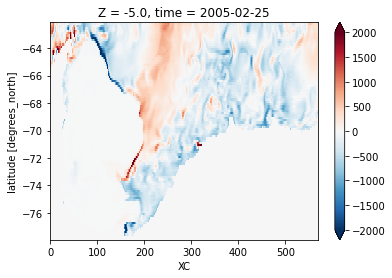

In [20]:
rhs_wg[10,0].drop('XC').load().plot(vmax=2e3)

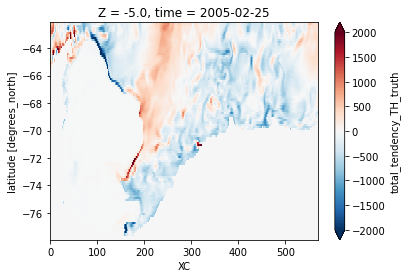

In [21]:
lhs_wg[10, 0].drop('XC').load().plot(vmax=2e3)

/srv/conda/envs/notebook/lib/python3.8/site-packages/holoviews/core/element.py:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is ():
/srv/conda/envs/notebook/lib/python3.8/site-packages/holoviews/core/layout.py:225: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is ():
/srv/conda/envs/notebook/lib/python3.8/site-packages/holoviews/element/tabular.py:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if heading is ():


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
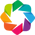

In [22]:
import datashader as ds
import holoviews as hv
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews import opts
hv.extension('bokeh')

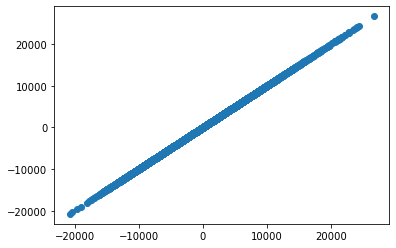

In [23]:
plt.scatter(rhs_wg.isel(time=35).values.ravel(), lhs_wg.where(coords_wg.Depth>200).isel(time=35).values.ravel())

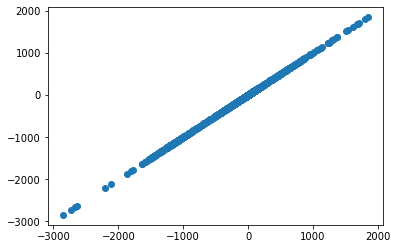

In [24]:
#looking at pts above 200m and that seems to solve a lot of the scattering issue...
plt.scatter(rhs_wg.isel(time=35).values.ravel(), lhs_wg.where(coords_wg.Depth<200).isel(time=35).values.ravel())

In [25]:
points = hv.Points((rhs_wg.isel(time=35, Z=20).values.ravel(),
                    lhs_wg.isel(time=35, Z=20).values.ravel()),label="Points")

In [26]:
points_timestp10 = hv.Points((rhs_wg.isel(time=10, Z=0).values.ravel(),
                    lhs_wg.isel(time=10, Z=0).values.ravel()),label="Points")

In [73]:
points_timestp200 = hv.Points((rhs_wg.isel(time=200, Z=8).values.ravel(),
                    lhs_wg.isel(time=200, Z=8).values.ravel()),label="Points")

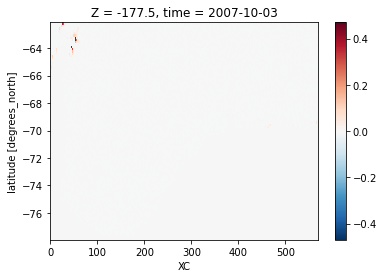

In [28]:
(rhs_wg.isel(time=200, Z=10) - lhs_wg.isel(time=200, Z=10)).drop('XC').plot()

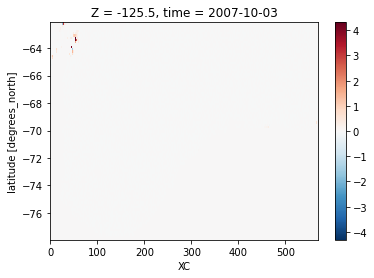

In [78]:
(rhs_wg.isel(time=200, Z=8) - lhs_wg.isel(time=200, Z=8)).drop('XC').plot()

In [75]:
rhs_wg.isel(time=200, Z=slice(8,11))

<xarray.DataArray (Z: 3, YC: 95, XC: 570)>
dask.array<getitem, shape=(3, 95, 570), dtype=float32, chunksize=(3, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -125.5 -150.0 -177.5
    time     datetime64[ns] 2007-10-03

In [29]:
extent = 5e5
one2one_curve = hv.Curve([[-extent, -extent], [extent, extent]], label='1:1')

In [74]:
#weird residual for `points_timestp200` variable for Z=[8:11]
b = datashade(points_timestp200)
b.opts(width=800, height=800) #* one2one_curve.opts(color='red', width=1)
# y-axis is lhs and x-axis is rhs, they seem to closely match but there are some strange error signals.
#this is a great plot to show you how well your lhs matches the rhs! (Should do this for all budgets!)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In [50]:
bad_pts = abs(rhs_wg - lhs_wg) > 5000
bad_pts

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<gt, shape=(438, 42, 95, 570), dtype=bool, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

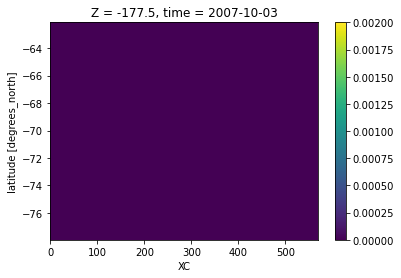

In [51]:
#error seems to be in the arctic cap and some other coastal feature
bad_pts[200,10].drop('XC').load().plot(vmax=0.002)

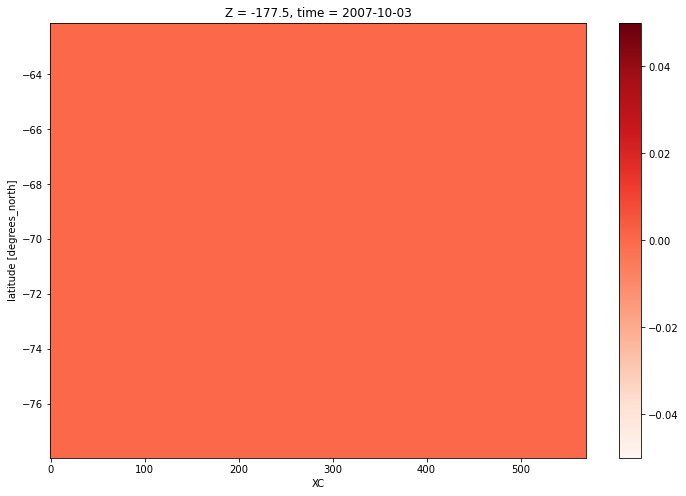

In [52]:
#error seems to be in the shortwave term where there is shallow waters. 
#What does MITgcm do when the water column depth is shorter than the depth of sw penetration (200m)?
#lhs doesn't have zeroes bc we didn't create it to fill rest of water columns with 0s, but rhs does when we created the sw term.
bad_pts.isel(Z=10, time=200).drop('XC').load().plot(figsize=(12, 8), cmap='Reds')
#coords.Depth.plot.contour(levels=[0, 200], colors='k')

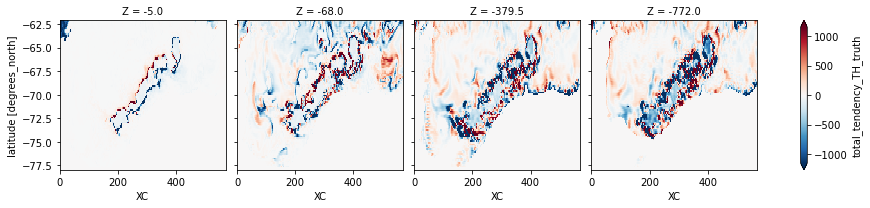

In [31]:
lhs_wg.isel(time=35, Z=[0, 5, 15, 20]).drop('XC').plot(robust=True, col='Z')

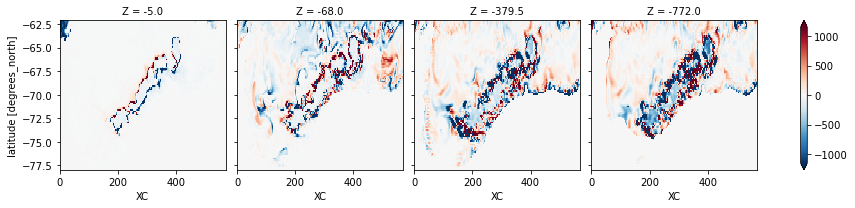

In [32]:
rhs_wg.isel(time=35, Z=[0, 5, 15, 20]).drop('XC').plot(robust=True, col='Z')

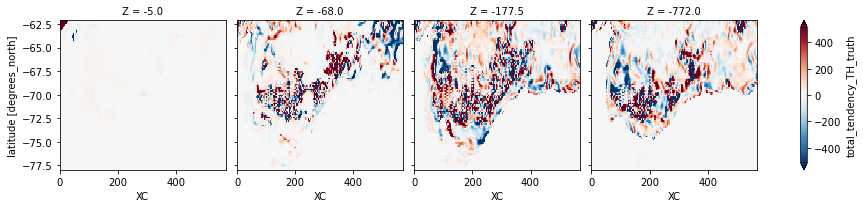

In [33]:
lhs_wg.isel(time=200, Z=[0, 5, 10, 20]).drop('XC').plot(robust=True, col='Z')

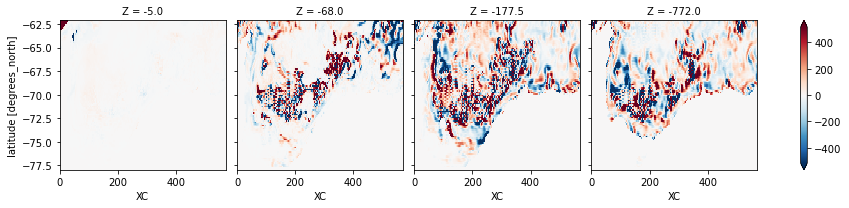

In [34]:
rhs_wg.isel(time=200, Z=[0, 5, 10, 20]).drop('XC').plot(robust=True, col='Z')

## Salt Scatter Plot

In [35]:
ds_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))

In [36]:
coords = ds_salt.coords.to_dataset().reset_coords().roll(XC=700)#, XG=700)
dsr = ds_salt.reset_coords(drop=True).roll(XC=700)#, XG=700)

<ipython-input-36-316000ff1181>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords = ds_salt.coords.to_dataset().reset_coords().roll(XC=700)#, XG=700)
<ipython-input-36-316000ff1181>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  dsr = ds_salt.reset_coords(drop=True).roll(XC=700)#, XG=700)


In [37]:
ds_salt = dsr

In [38]:
ds_salt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 243.41667 243.58334 ... 243.25
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [39]:
rhs_salt = (ds_salt.conv_horiz_adv_flux_SLT +
            ds_salt.conv_horiz_diff_flux_SLT + 
            ds_salt.conv_vert_adv_flux_SLT + 
            ds_salt.conv_vert_diff_flux_SLT +
            ds_salt.surface_flux_conv_SLT +
           ds_salt.lin_fs_correction_SLT)

lhs_salt = ds_salt.total_tendency_SLT_truth

In [40]:
rhs_slt_wg = rhs_salt.isel(**lat_range, **lon_range)

In [41]:
lhs_slt_wg = lhs_salt.isel(**lat_range, **lon_range)

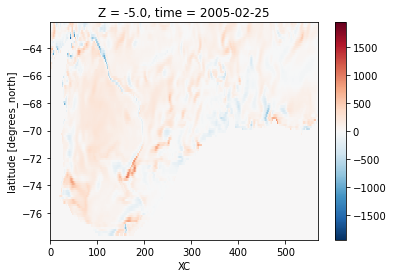

In [42]:
rhs_slt_wg.isel(time=10, Z=0).drop('XC').load().plot()

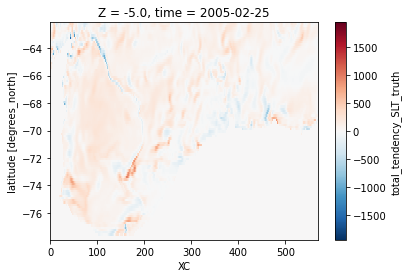

In [43]:
lhs_slt_wg.isel(time=10, Z=0).drop('XC').load().plot()

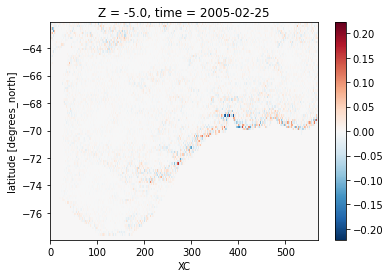

In [44]:
(rhs_slt_wg.isel(time=10, Z=0) - lhs_slt_wg.isel(time=10, Z=0)).drop('XC').plot()

In [45]:
points_salt = hv.Points((rhs_slt_wg.isel(time=10, Z=0).values.ravel(),
                         lhs_slt_wg.isel(time=10, Z=0).values.ravel()),label="Points")

In [46]:
points_salt_timestp200 = hv.Points((rhs_slt_wg.isel(time=200, Z=10).values.ravel(),
                         lhs_slt_wg.isel(time=200, Z=10).values.ravel()),label="Points")

In [47]:
extent_salt = 5e5
one2one_curve_salt = hv.Curve([[-extent_salt, -extent_salt], [extent_salt, extent_salt]], label='1:1')

In [48]:
b_salt = datashade(points_salt_timestp200)
b_salt.opts(width=800, height=800) #* one2one_curve_salt.opts(color='red', width=1)
#better 1:1 than temperature so diff in temp must be how total tendency is handled for sw penetration.

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

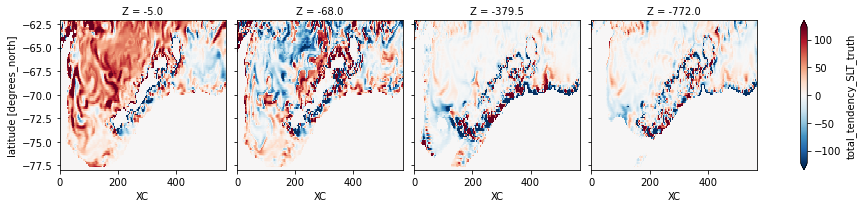

In [61]:
lhs_slt_wg.isel(time=35, Z=[0, 5, 15, 20]).drop('XC').plot(robust=True, col='Z')

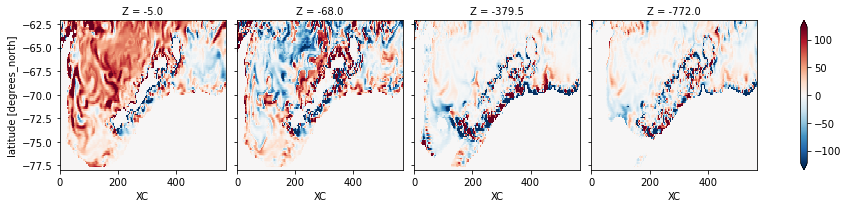

In [62]:
rhs_slt_wg.isel(time=35, Z=[0, 5, 15, 20]).drop('XC').plot(robust=True, col='Z')